# VCS SV40 NLS Analysis

## Objectives
### Import datasets

### Filter and annotate variants
Count cutoff, annotation using variant name.

### Determine variant scores
Variant scores will be determined in a manner similar to that published by Matreyek et al. (2018).

### Calculate position-based median scores
These median scores can be mapped to the NLS crystal structure

## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from plotnine.data import *
import scipy as stats
import sys
import itertools
import enrich2_analysis_package as enrich2

In [2]:
## make ggplot classic looking
ggplot_classic = theme_classic() 

In [3]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Import datasets

In [4]:
# import data, ensuring to reset the index
all_data = pd.concat([
enrich2.import_replicate(['R1T1_0ms_lib', 'R1T1_50ms_lib', 'R1T1_200ms_lib', 'R1T1_800ms_lib'], 'R1T1', folder_loc = '../data/'),
enrich2.import_replicate(['R1T2_0ms_lib', 'R1T2_50ms_lib', 'R1T2_200ms_lib', 'R1T2_800ms_lib'], 'R1T2', folder_loc = '../data/'),
enrich2.import_replicate(['R2T1_0ms_lib', 'R2T1_50ms_lib', 'R2T1_200ms_lib', 'R2T1_800ms_lib'], 'R2T1', folder_loc = '../data/'),
enrich2.import_replicate(['R2T2_0ms_lib', 'R2T2_50ms_lib', 'R2T2_200ms_lib', 'R2T2_800ms_lib'], 'R2T2', folder_loc = '../data/'),
enrich2.import_replicate(['R2T3_0ms_lib', 'R2T3_50ms_lib', 'R2T3_200ms_lib', 'R2T3_800ms_lib'], 'R2T3', folder_loc = '../data/'),
], axis = 0, ignore_index = True)
all_data.to_csv('processed_nls_counts.csv')

## Preliminary filtering and variant annotation
(a) filter variants based on low count cutoff
(b) parse variant name --> nucleotide and amino acid changes
(c) exclude all variants that are not NNK
(d) concatenate the counts of nucleotide variants that result in the same amino acid changes

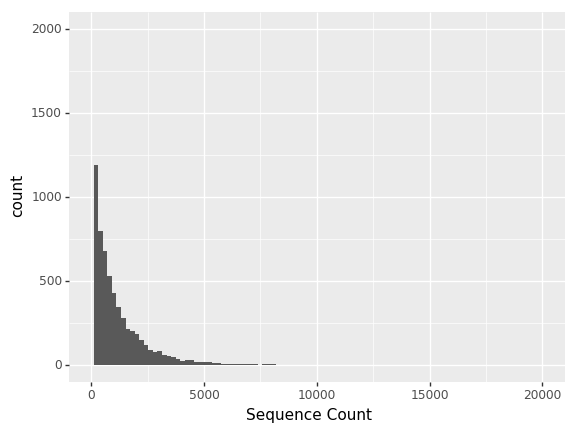

<ggplot: (-9223371897339320695)>

In [6]:
# filter any variants with count < 5
all_data = enrich2.filter_counts(all_data, 5)

# parse variant name into amino acid identities
parsed_variants = enrich2.annotate_variants(all_data, "GAGGCTCCTAAAAAGAAGAGAAAGGTAGGTATC")

# plot counts
ggplot(all_data, aes(x = 'count')) + geom_histogram(bins = 100) + xlim(0, 20000) + ylim(0, 2000) + labs(x = "Sequence Count")

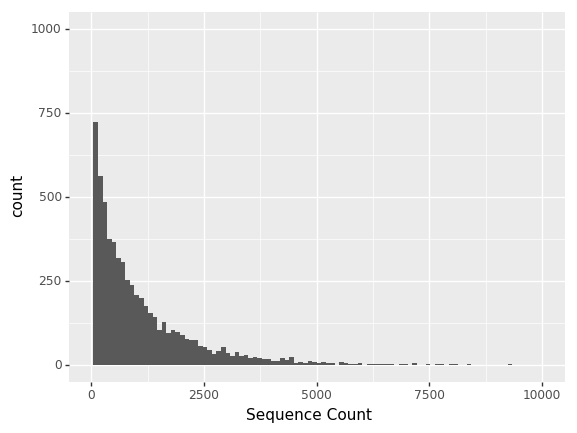

<ggplot: (139515129804)>

In [7]:
# filter variants for those with just one codon variant
parsed_variants = enrich2.filter_unlink_variants(parsed_variants, 1, "GAGGCTCCTAAAAAGAAGAGAAAGGTAGGTATC")

# plot counts again
ggplot(parsed_variants, aes(x = 'count')) + geom_histogram(bins = 100) + xlim(0, 10000) + ylim(0, 1000) + labs(x = "Sequence Count")

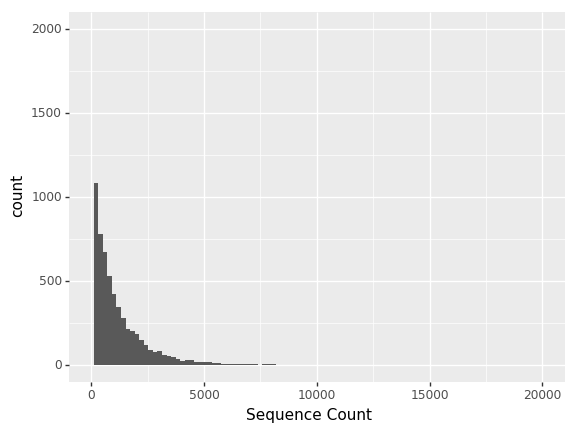

<ggplot: (-9223371897339332387)>

In [8]:
# filter variants based on NNK
parsed_variants = enrich2.filter_nnk(parsed_variants)
ggplot(parsed_variants, aes(x = 'count')) + geom_histogram(bins = 100) + xlim(0, 20000) + ylim(0, 2000) + labs(x = "Sequence Count")

In [9]:
# concatenate the counts of all nucleotide variants
concat_variants = enrich2.concatenate_variants(parsed_variants)
concat_variants.iloc[:10,]

,count,variant,bin_name,bin_num,replicate,aa_pos,wt_aa,mt_aa,mt_type
0,1479,E1*,../data/R1T1_0ms_lib,1,R1T1,1,E,*,non
1,1789,E1*,../data/R1T1_50ms_lib,2,R1T1,1,E,*,non
2,828,E1*,../data/R1T1_200ms_lib,3,R1T1,1,E,*,non
3,1386,E1*,../data/R1T1_800ms_lib,4,R1T1,1,E,*,non
4,453,E1*,../data/R1T2_0ms_lib,1,R1T2,1,E,*,non
5,892,E1*,../data/R1T2_50ms_lib,2,R1T2,1,E,*,non
6,130,E1*,../data/R1T2_200ms_lib,3,R1T2,1,E,*,non
7,152,E1*,../data/R1T2_800ms_lib,4,R1T2,1,E,*,non
8,429,E1*,../data/R2T1_0ms_lib,1,R2T1,1,E,*,non
9,683,E1*,../data/R2T1_50ms_lib,2,R2T1,1,E,*,non


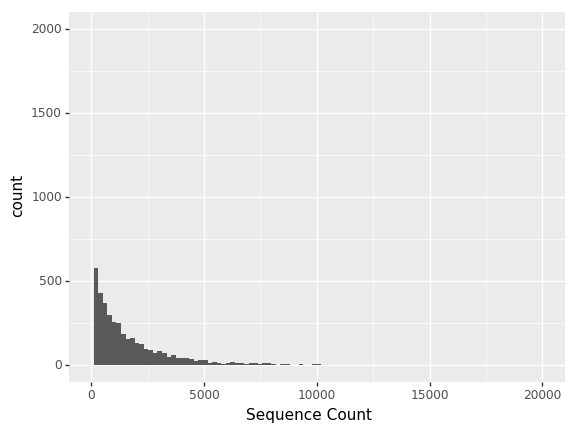

<ggplot: (-9223371897339350335)>

In [10]:
# replot counts
ggplot(concat_variants, aes(x = 'count')) + geom_histogram(bins = 100) + xlim(0, 20000) + ylim(0, 2000) + labs(x = "Sequence Count")

## Generate Scores
Generate scores using the method published by Matreyek et al. 2018, with wild-type at 1; scores more nuclear than wild-type > 1; and scores less nuclear than wild-type < 1.

calculating frequencies...
frequences calculated
calculating scores
scores calculated
wt raw score is0.12919578342011193
mean value of bottom 10 percent of raw scores is 0.07372985778370583
scaling factor is 18.029087021016583
wt raw score is0.12919578342011193
mean value of bottom 10 percent of raw scores is 0.07372985778370583
scaling factor is 18.029087021016583
wt raw score is0.12640320820542914
mean value of bottom 10 percent of raw scores is 0.08457432407621653
scaling factor is 23.906925102542154
wt raw score is0.13377007387904646
mean value of bottom 10 percent of raw scores is 0.06321428304951851
scaling factor is 14.173181084684192
wt raw score is0.13720955140115415
mean value of bottom 10 percent of raw scores is 0.06932819965866134
scaling factor is 14.731586427351791
wt raw score is0.13683054460566615
mean value of bottom 10 percent of raw scores is 0.06427727709635941
scaling factor is 13.782976760787864


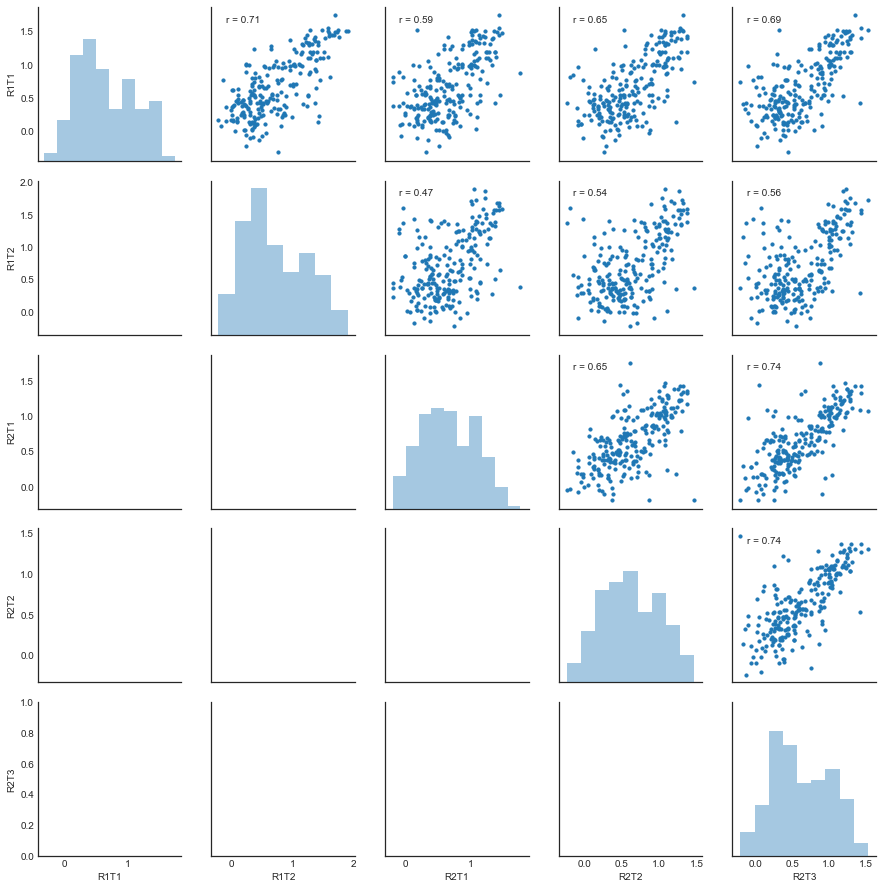

In [11]:
# generate scores and check experiment frequencies (frequency of variants across the 4 bins)
scores_vampseq = enrich2.calc_flowbin_scores(concat_variants, scaling = 'WT1_subtract')

# check replicate correlations
enrich2.plot_correlation(scores_vampseq, 'scaled_score')
plt.show()

In [12]:
# summarize the scores without any filtering
summary_df = enrich2.summarize_scores(scores_vampseq)

summary_df
#summary_df.to_csv('summary_scores_all_vampseq.csv')

,aa_pos,mt_aa,mt_type,wt_aa,mean_raw_score,std_err_raw_score,mean_scaled_score,std_err_scaled_score
variant,,,,,,,,
A2*,2,*,non,A,0.102884,0.022333,0.471065,3.709969e-01
A2A,2,A,syn,A,0.125506,0.012015,0.887425,1.642518e-01
A2C,2,C,mis,A,0.120591,0.015655,0.808797,2.902263e-01
A2D,2,D,mis,A,0.099901,0.024831,0.437608,3.925092e-01
A2E,2,E,mis,A,0.092109,0.012215,0.363148,1.894249e-01
A2F,2,F,mis,A,0.095003,0.016738,0.369407,2.898216e-01
A2G,2,G,mis,A,0.107907,0.003364,0.588531,9.857546e-02
A2H,2,H,mis,A,0.131021,0.019242,0.975979,3.003779e-01
A2I,2,I,mis,A,0.149269,0.006370,1.285646,1.303898e-01


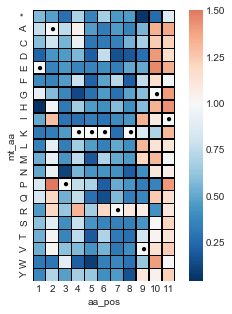

In [13]:
# plot the heatmap without any filtering
heatmap = enrich2.plot_heatmap(enrich2.summarize_scores(scores_vampseq), "GAGGCTCCTAAAAAGAAGAGAAAGGTAGGTATC")

#heatmap.figure.savefig('fig3b_nofiltering_mean.png', dpi = 600)

## Filter scores generated with low frequency counts
Variants that are detected at low frequency in the sequencing data have more noise, contributing to poorly-estimated scores. By examining how correlations improve as a function of a variant sequencing frequency filter, we can pick a sequencing frequency filter that (a) retains almost all variants and (b) removes variants that are likely poorly estimated. 

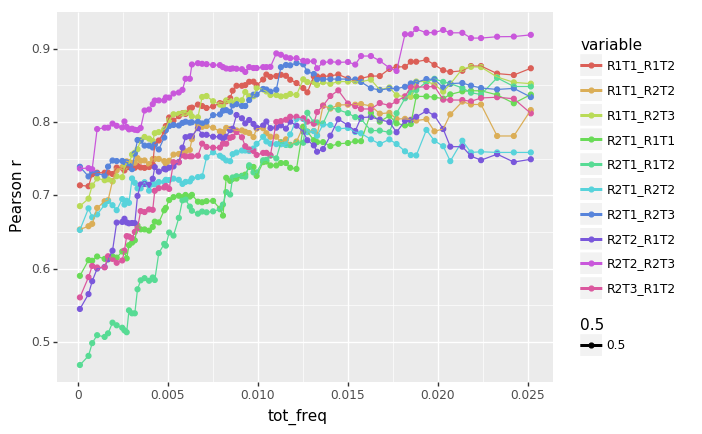

<ggplot: (139514351238)>

In [14]:
# the test_pearson_function makes two plots: one that looks at the average pearson's correlation coefficient as a function of a frequency filter; and another that plots the number of variants that still have scores after the frequency filter is applied
plots = enrich2.test_pearson_function(scores_vampseq, 'tot_freq')

# plots the pearson's R
plots[0]

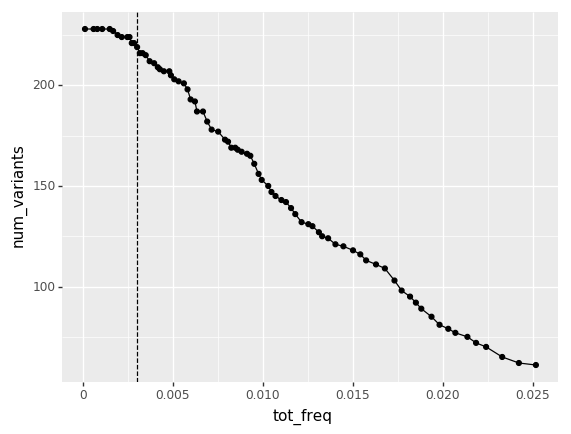

<ggplot: (139514361429)>

In [15]:
# plots the number of variants that have scores.
plots[1] + geom_vline(xintercept = 0.003, linetype = 'dashed')

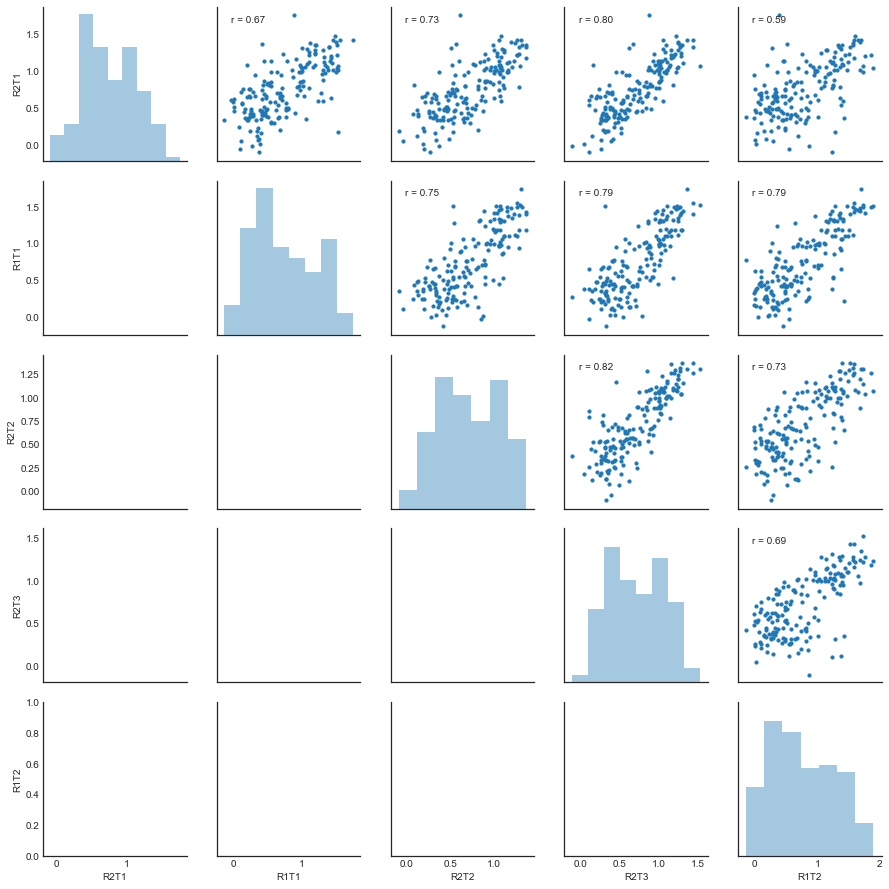

In [16]:
# based on these results, filter at 0.003 total frequency
scores_vampseq_filtered = enrich2.filter_score_df(scores_vampseq, 'tot_freq',0.003)
corr = enrich2.plot_correlation(scores_vampseq_filtered, 'scaled_score')

#corr.savefig('replicate_correlations.png', dpi=300)

corr
plt.show()

## Summarize filtered scores
Summarize the filtered scores by averaging scores across replicates and computing a standard error where possible.

In [17]:
summary_scores = enrich2.summarize_scores(scores_vampseq_filtered)
summary_scores.to_csv('ST3.csv')
summary_scores

,aa_pos,mt_aa,mt_type,wt_aa,mean_raw_score,std_err_raw_score,mean_scaled_score,std_err_scaled_score
A2*,2,*,non,A,0.102884,0.022333,0.471065,3.709969e-01
A2A,2,A,syn,A,0.125506,0.012015,0.887425,1.642518e-01
A2C,2,C,mis,A,0.120591,0.015655,0.808797,2.902263e-01
A2D,2,D,mis,A,0.099901,0.024831,0.437608,3.925092e-01
A2E,2,E,mis,A,0.092109,0.012215,0.363148,1.894249e-01
A2F,2,F,mis,A,0.095003,0.016738,0.369407,2.898216e-01
A2G,2,G,mis,A,0.107907,0.003364,0.588531,9.857546e-02
A2H,2,H,mis,A,0.131021,0.019242,0.975979,3.003779e-01
A2I,2,I,mis,A,0.149269,0.006370,1.285646,1.303898e-01
A2K,2,K,mis,A,0.093499,0.014214,0.339723,3.287912e-01


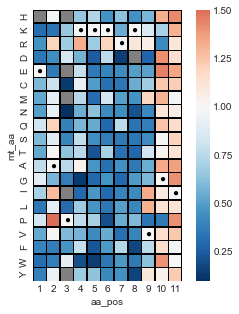

In [18]:
# summarize scores, remove stop codons, and reorganize mt_aa by physicochemical features
## filter scores for mis and syn variants; nonsense variants by definition cannot have a localization
summary_scores_no_nonsense = summary_scores[summary_scores['mt_type'] != 'non'].dropna()

## factorize mt aa in an ordered fashion
from pandas.api.types import CategoricalDtype
aa_phys = CategoricalDtype(categories=['H','K','R','D','E','C','M','N','Q','S','T','A','G','I','L','P','V','F','W','Y'], ordered = True)
summary_scores_no_nonsense.mt_aa = summary_scores_no_nonsense.mt_aa.astype(aa_phys)


# plot a heatmap of the summarizeed scores
plot = enrich2.plot_heatmap(summary_scores_no_nonsense, 'GAGGCTCCTAAAAAGAAGAGAAAGGTAGGTATC')

plot.figure.savefig('F2D.png', dpi = 600)

(210, 8)


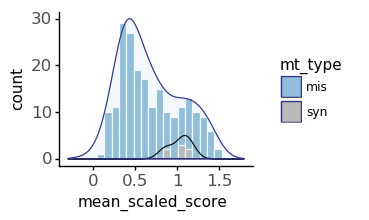

<ggplot: (139514063280)>

In [22]:
# filter subsets of data for density plot
mis_scores = summary_scores[summary_scores['mt_type'] == 'mis']
syn_scores = summary_scores[summary_scores['mt_type'] == 'syn']

print(mis_scores.shape)

# base histogram
d = ggplot(aes(x = 'mean_scaled_score', fill = 'mt_type'), data = summary_scores_no_nonsense) + geom_histogram(y = 'identity', bins = 25, color = 'white')
# add density
d = d + geom_density(aes(y = 'stat(scaled)*5'), alpha = 0.1, color = 'black', data = syn_scores) + geom_density(aes(y = 'stat(scaled)*30'), alpha = 0.1, color = '#313695', data = mis_scores)
## change themes
d = d + scale_fill_manual(values = ['#91bfdb', '#bababa']) + theme(text = element_text(size = 16)) + ggplot_classic + theme(axis_text=element_text(size=12)) + xlim(-0.3,1.8)

ggsave(d, 'F2C.png', dpi = 600, width = 2.5, height = 2)

d

In [ ]:
## now, going to plot binding energies reported by Hodel et al (2001) to see if they correlate with scores
bind_E = pd.DataFrame({'aa_pos': [3,4,5,6,7,8,9, 5, 5, 5], 
                                 'mt_aa':[ 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'T', 'R', 'M'],
                                 'Kd':[36, 16.5, 3000, 335, 38, 310, 53, 3000, 850, 6500],
                                 'Kd_err':[2, 1, 1400, 7, 2, 100, 4, 1414, 200, 700]})
# harmonize datatypes
bind_E.aa_pos = bind_E.aa_pos.astype('str')
bind_E.mt_aa = bind_E.mt_aa.astype('str')

# need to remove WT to get this to work
summary_scores.aa_pos = summary_scores.aa_pos.astype('str')
summary_scores.mt_aa = summary_scores.mt_aa.astype('str')

bind_E = pd.merge(bind_E, summary_scores, on = ['aa_pos', 'mt_aa'])
bind_E['variant'] = bind_E[['wt_aa', 'aa_pos', 'mt_aa']].apply(lambda x: ''.join(x), axis = 1)

# add WT back in
bind_E.loc[10] = pd.Series([0, 'WT', 9, 4, 'WT', 'WT', 1, 0, 1, 0, 'WT'], index = bind_E.columns)

# Kd's are ratios, so should be log-transformed
bind_E['logKd'] = np.log10(bind_E.Kd)
bind_E['logKd_se'] = np.log10(bind_E.Kd_err)

# compute error bars
bind_E['err_xmin'] = bind_E.mean_scaled_score-(bind_E.std_err_scaled_score)
bind_E['err_xmax'] = bind_E.mean_scaled_score+(bind_E.std_err_scaled_score)
bind_E['err_ymin'] = np.log10(bind_E.Kd-(bind_E.Kd_err))
bind_E['err_ymax'] = np.log10(bind_E.Kd+(bind_E.Kd_err))

# compute error bar dataframe
logKd_errs = pd.melt(bind_E[['variant','mean_scaled_score', 'err_ymin', 'err_ymax']], id_vars = ['variant', 'mean_scaled_score'])
scale_score_errs = pd.melt(bind_E[['variant','logKd', 'err_xmin', 'err_xmax']], id_vars = ['variant', 'logKd'])

# compute r value
pearson_r = bind_E[['logKd','mean_scaled_score']].corr().iloc[0,1]

#plt_noerrs = 
plt = ggplot(aes(x = 'mean_scaled_score', y = 'logKd'), data = bind_E) + geom_point() + geom_smooth(method = 'lm', se = False) + ggplot_classic + annotate("text", x = 0.9, y = 3.75, label = 'r = %.2f' % (pearson_r))

plt_errs = plt + geom_line(aes(y = 'logKd', x = 'value', group = 'variant'), alpha = 0.2, data = scale_score_errs) + geom_line(aes(y = 'value', x = 'mean_scaled_score', group = 'variant'), alpha = 0.2, data = logKd_errs)

ggsave(plt_errs, 'SF3A.png', dpi = 600, width = 2.5, height = 2.5)


plt_errs

In [ ]:
bind_E[['logKd','mean_scaled_score']].corr().iloc[0,1]

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 6):
    display(summary_scores)

In [ ]:
# look at the average effect of a variant on function across each position. Note that positions 5 through 8 (core NLS region) are most sensitive
median_scores = summary_scores.groupby('aa_pos').agg('median')
# drop the wt row
median_scores = median_scores.drop('w')
median_scores.index = median_scores.index.astype('int')
median_scores = median_scores.sort_index()
median_scores_structure = median_scores.iloc[2:9]
median_scores
to_plot=summary_scores.loc[summary_scores.aa_pos != 'w']
to_plot.aa_pos = to_plot.aa_pos.astype('int')
ggplot(data=to_plot, mapping=aes(x='aa_pos',y='mean_scaled_score')) + geom_point() + stat_summary(color='red')